#Importing the libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import pickle

#Importing Train Dataset

In [52]:
df_train = pd.read_excel('Data_Train.xlsx')

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


#Checking for null values

In [54]:
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [55]:
df_train.dropna(inplace = True)

In [56]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


#EDA


> From description we can see that Date_of_Journey is a object data type,Therefore, we have to convert this datatype into timestamp for predication.

For this we require **Pandas to_datetime function** to convert object data type to datetime dtype.

**.dt.day method will extract only day of that date**, **.dt.month method will extract only month of that date**



In [57]:
df_train["Journey_day"] = pd.to_datetime(df_train.Date_of_Journey, format="%d/%m/%Y").dt.day

df_train["Journey_month"] = pd.to_datetime(df_train["Date_of_Journey"], format = "%d/%m/%Y").dt.month

df_train.drop(["Date_of_Journey"], axis = 1, inplace = True)

df_train.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [58]:
df_train["Dep_hour"] = pd.to_datetime(df_train["Dep_Time"]).dt.hour

df_train["Dep_min"] = pd.to_datetime(df_train["Dep_Time"]).dt.minute

df_train.drop(["Dep_Time"], axis = 1, inplace = True)

df_train.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [59]:
df_train["Arrival_hour"] = pd.to_datetime(df_train.Arrival_Time).dt.hour

df_train["Arrival_min"] = pd.to_datetime(df_train.Arrival_Time).dt.minute

df_train.drop(["Arrival_Time"], axis = 1, inplace = True)

df_train.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [60]:
duration = list(df_train["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))    #Extract mins from duration

In [61]:
df_train["Duration_hours"] = duration_hours
df_train["Duration_mins"] = duration_mins

In [62]:
df_train.drop(["Duration"], axis = 1, inplace = True)

df_train.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [63]:
df_train.describe()

,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,9087.214567,13.509081,4.708575,12.491013,24.409287,13.349186,24.690601,10.244898,28.326624
std,4611.548810,8.479363,1.164408,5.748820,18.767801,6.859317,16.506808,8.494916,16.945817
min,1759.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5277.000000,6.000000,3.000000,8.000000,5.000000,8.000000,10.000000,2.000000,15.000000
50%,8372.000000,12.000000,5.000000,11.000000,25.000000,14.000000,25.000000,8.000000,30.000000
75%,12373.000000,21.000000,6.000000,18.000000,40.000000,19.000000,35.000000,15.000000,45.000000
max,79512.000000,27.000000,6.000000,23.000000,55.000000,23.000000,55.000000,47.000000,55.000000


#Handling Categorical Data
> One Hot Encoding

In [64]:
df_train["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [65]:
Airline = df_train[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [66]:
df_train["Source"].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [67]:
Source = df_train[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [68]:
df_train["Destination"].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [69]:
Destination = df_train[["Destination"]]

Destination = pd.get_dummies(Destination, drop_first = True)

Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


#Dropping Columns

*   Dropping the Route Column as Total_Stops column gives the same information as Route column
*   Dropping the Additional_Info Column because it contains 80% of no_info 



In [70]:
df_train['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
Red-eye flight                     1
2 Long layover                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

In [71]:
df_train.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [72]:
df_train["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [73]:
df_train.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

#Creating a new Train dataset 

In [74]:
train = pd.concat([df_train, Airline, Source, Destination], axis = 1)

In [75]:
train.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [76]:
train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [77]:
train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#Importing Test Data

In [78]:
df_test = pd.read_excel('Test_set.xlsx')

#EDA


> From description we can see that Date_of_Journey is a object data type,\ Therefore, we have to convert this datatype into timestamp for predication.

For this we require **Pandas to_datetime function** to convert object data type to datetime dtype.

**.dt.day method will extract only day of that date**, **.dt.month method will extract only month of that date**



In [79]:
df_test["Journey_day"] = pd.to_datetime(df_test.Date_of_Journey, format="%d/%m/%Y").dt.day

df_test["Journey_month"] = pd.to_datetime(df_test["Date_of_Journey"], format = "%d/%m/%Y").dt.month

df_test.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [80]:
df_test["Dep_hour"] = pd.to_datetime(df_test["Dep_Time"]).dt.hour

df_test["Dep_min"] = pd.to_datetime(df_test["Dep_Time"]).dt.minute

df_test.drop(["Dep_Time"], axis = 1, inplace = True)

In [81]:
df_test["Arrival_hour"] = pd.to_datetime(df_test.Arrival_Time).dt.hour

df_test["Arrival_min"] = pd.to_datetime(df_test.Arrival_Time).dt.minute

df_test.drop(["Arrival_Time"], axis = 1, inplace = True)

In [82]:
duration = list(df_test["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [83]:
df_test["Duration_hours"] = duration_hours

df_test["Duration_mins"] = duration_mins

df_test.drop(["Duration"], axis = 1, inplace = True)

#Handling Categorical Data
> One Hot Encoding

In [84]:
df_test["Airline"].value_counts()


Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Vistara Premium economy                2
Jet Airways Business                   2
Name: Airline, dtype: int64

In [85]:
Airline = pd.get_dummies(df_test["Airline"], drop_first=True)
Airline.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy
0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [86]:
print(df_test["Source"].value_counts())

Source = pd.get_dummies(df_test["Source"], drop_first=True)

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64


In [87]:
print(df_test["Destination"].value_counts())

Destination = pd.get_dummies(df_test["Destination"], drop_first=True)

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64


In [88]:
df_test.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,6,6,17,30,4,25,10,55
1,IndiGo,Kolkata,Banglore,CCU → MAA → BLR,1 stop,No info,12,5,6,20,10,20,4,0
2,Jet Airways,Delhi,Cochin,DEL → BOM → COK,1 stop,In-flight meal not included,21,5,19,15,19,0,23,45
3,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,1 stop,No info,21,5,8,0,21,0,13,0
4,Air Asia,Banglore,Delhi,BLR → DEL,non-stop,No info,24,6,23,55,2,45,2,50


#Dropping Columns

*   Dropping the Route Column as Total_Stops column gives the same information as Route column
*   Dropping the Additional_Info Column because it contains 80% of no_info 



In [89]:
df_test.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [90]:
df_test.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

#Creating a new Test dataset 

In [91]:
test = pd.concat([df_test, Airline, Source, Destination], axis = 1)

In [92]:
test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [93]:
test.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,17,30,4,25,10,55,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,1,12,5,6,20,10,20,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,15,19,0,23,45,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,21,5,8,0,21,0,13,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,24,6,23,55,2,45,2,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#Feature Selection

In [94]:
train.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [95]:
x = train.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour','Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo','Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers','Airline_Multiple carriers Premium economy', 'Airline_SpiceJet','Airline_Trujet', 'Airline_Vistara', 
       'Airline_Vistara Premium economy','Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai','Destination_Cochin', 
       'Destination_Delhi', 'Destination_Hyderabad','Destination_Kolkata', 'Destination_New Delhi']]
x.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5,25,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [96]:
y = train.iloc[:,1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

##Heatmap

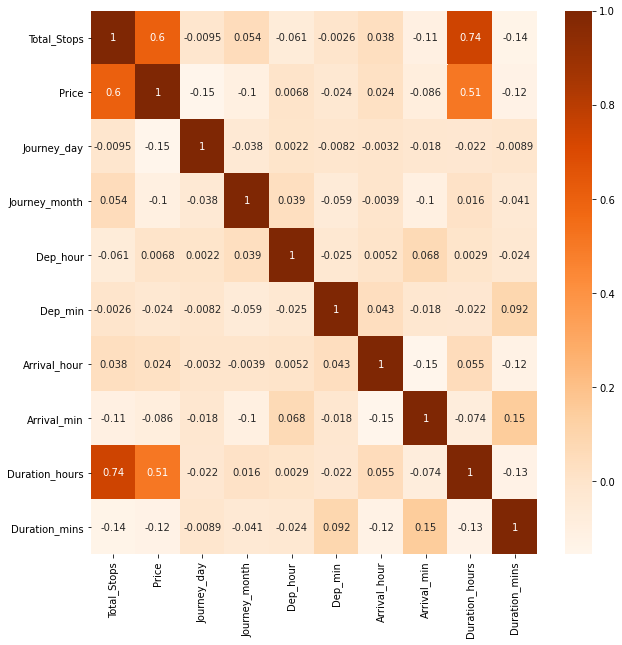

In [97]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train.corr(), annot = True, cmap = "Oranges")
plt.show()

#Scatter plot


> Plotting a scatter plot graph betwwen Airline column and Price column



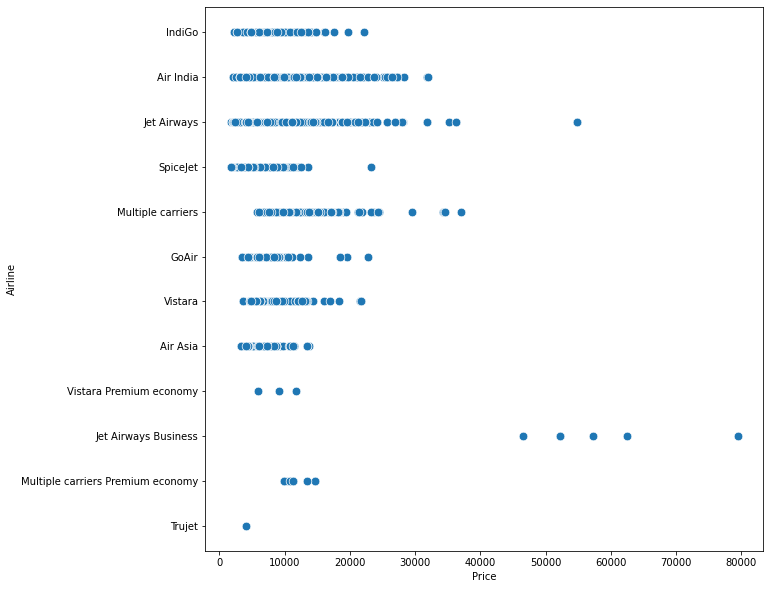

In [98]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_train, x="Price", y="Airline",s=75)

#Random Forest Model

1.   Splitting the dataset into train and test 
2.   Importing the model
3.   Fit the data
4.   Predict with respect to xtest
5.   Check RSME Score as it is Regression
6.   Plot graph








In [99]:
accu = []
for i in range (100):
  xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.20, random_state=i)
  regressor = RandomForestRegressor()
  regressor.fit(xtrain, ytrain)
  ypred = regressor.predict(xtest)
  accu.append(r2_score(ytest, ypred))

In [100]:
np.argmax(accu)

13

In [101]:
accu[np.argmax(accu)]

0.8451648230499721

In [102]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.20, random_state=np.argmax(accu))
regressor = RandomForestRegressor()
regressor.fit(xtrain, ytrain)
ypred = regressor.predict(xtest)   
accu.append(r2_score(ytest, ypred))

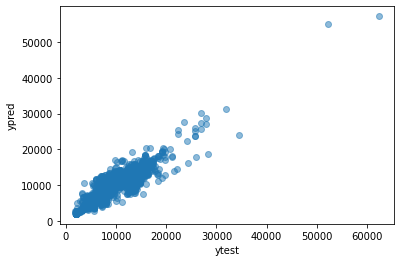

In [103]:
plt.scatter(ytest, ypred, alpha = 0.5)
plt.xlabel("ytest")
plt.ylabel("ypred")
plt.show()

In [104]:
print('MAE:', metrics.mean_absolute_error(ytest, ypred))
print('MSE:', metrics.mean_squared_error(ytest, ypred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

MAE: 1156.6655887225263
MSE: 3273300.084823678
RMSE: 1809.226377439727


In [105]:
metrics.r2_score(ytest, ypred)

0.8468353593850728

#Hyperparameter Tuning
1.   GridSearchCV
2.   Assign hyperparameters 
3.   Fit the model
4.   Check the best parameters and best score





In [110]:
GBR = GradientBoostingRegressor()

In [111]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

In [ ]:
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(xtrain, ytrain)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

#Saving the model and reusing it again

In [ ]:
file = open('flight.pkl', 'wb')
pickle.dump(regressor, file)

In [ ]:
model = open('flight.pkl', 'rb')
forest = pickle.load(model)

In [ ]:
y_prediction = forest.predict(xtest)

In [ ]:
metrics.r2_score(ytest, y_prediction)